In [1]:
import sys
sys.path.append("proto")
from dicomUtils import *

In [2]:
import cv2
import matplotlib.pyplot as plt
def imshow_single(img, title):
    fig,ax = plt.subplots()
    ax.imshow(img,cmap='gray')
    ax.set_title(title)
def imshow_double(img1, img2, title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img1,cmap='gray')
    ax2.imshow(img2,cmap='gray')
    fig.suptitle(title, fontsize=16)
def imshow_15(sup_title, images, titles):
    fig=plt.figure(figsize=(16, 16))
    columns = 3
    rows = 5
    for i in range(len(images)):
        img = images[i]
        ax=fig.add_subplot(rows, columns, i+1)
        ax.title.set_text(titles[i])#('{:.4f}'.format(titles[i]))
        plt.axis('off')
        plt.imshow(img,cmap='gray')
    fig.suptitle(sup_title, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
    plt.savefig(sup_title + '.png')
def imshow_25(sup_title, images, titles):
    fig=plt.figure(figsize=(16, 16))
    columns = 5
    rows = 5
    for i in range(len(images)):
        img = images[i]
        ax=fig.add_subplot(rows, columns, i+1)
        ax.title.set_text(titles[i])#('{:.4f}'.format(titles[i]))
        plt.axis('off')
        plt.imshow(img,cmap='gray')
    fig.suptitle(sup_title, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
    plt.savefig(sup_title + '.png')

In [3]:
from util.slice_score import *
def getSingleImage(path):
    fs = pydicom.dcmread(path)
    img = fs.pixel_array
    return [img, getPreprocessImage(img)]

In [4]:
f1 = '../data/PACS/IRB02/27_WATERPOSTAxLAVAFLEXLOWER/series027-0054.dcm'
f2 = '../data/PACS/IRB02/14_DWIAXUPPER/series014-0072.dcm'

# '../data/PACS/IRB05/13_DWIAXUPPER/series013-0050.dcm'
# '../data/PACS/IRB05/2100_FATPOSTAXLAVAFLEXUPPER/series2100-0040.dcm'
img, [F,B,c,f,b] = getSingleImage(f1)
img2,[F2,B2,c2,f2,b2] = getSingleImage(f2)

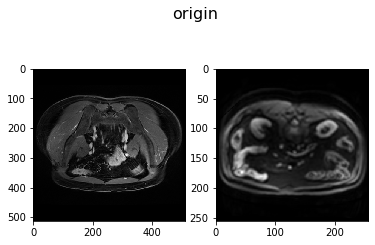

In [5]:
imshow_double(img,img2,"origin")

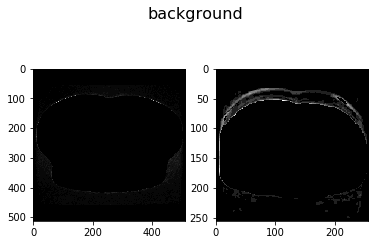

In [6]:
imshow_double(B,B2,"background")

In [7]:
def getQI1(F, B, c, f, b):
    bgf = B.flatten()
    hist,bins = np.histogram([x for x in bgf if x > 0],256,[0,256])
    bin_max = np.where(hist == hist.max())[0]
    x1 = bins[bin_max[0]]
    threshold_hist = [x for x in hist[bin_max[0]:] if x > 0]
    return sum(threshold_hist)/(len(bgf) - np.sum(c))

In [8]:
import math
def getQI2(F, B, c, f, b ):
    bgf = B.flatten()
    hist,bins = np.histogram([x for x in bgf if x > 0],256,[0,256])
    bin_max = np.where(hist == hist.max())[0]
    x1 = bins[bin_max[0]]
    threshold_hist = []
    threshold_bins = []

    for i in range(bin_max[0], len(hist)):
        if(hist[i] > 0):
            threshold_hist.append(hist[i])
            threshold_bins.append(i)
    msize = len(bgf)
    sigma = np.nanstd(b)
    gof=.0
    threshold_value = hist.max() * 0.5
    
#     print(len(threshold_bins))
    for yi in threshold_bins:
        if(yi > threshold_value):
            continue
        yif = yi / 255.0
        pdf = yif*math.exp(0.5 * (yif**2/sigma))/sigma
        gof += abs(hist[yi]/msize - pdf)
    return sum(hist)/(msize - np.sum(c)), gof

In [9]:
def psnr(img1, img2):
    mse = np.square(np.subtract(img1, img2)).mean()
    return 20 * np.log10(np.nanmax(img1) / np.sqrt(mse))
def bpsnr(F, B, c, f, b):
    I_hat = median(B/np.max(B), square(5))
    return psnr(B, I_hat)
def fpsnr(F, B, c, f, b):
    I_hat = median(F/np.max(F), square(5))
    return psnr(F, I_hat)

In [11]:
import numpy as np
from cv2 import imread
from skimage import img_as_float
import time

def im2patch(im, pch_size, stride=1):
    '''
    Transform image to patches.
    Input:
        im: 3 x H x W or 1 X H x W image, numpy format
        pch_size: (int, int) tuple or integer
        stride: (int, int) tuple or integer
    '''
    if isinstance(pch_size, tuple):
        pch_H, pch_W = pch_size
    elif isinstance(pch_size, int):
        pch_H = pch_W = pch_size
    else:
        sys.exit('The input of pch_size must be a integer or a int tuple!')

    if isinstance(stride, tuple):
        stride_H, stride_W = stride
    elif isinstance(stride, int):
        stride_H = stride_W = stride
    else:
        sys.exit('The input of stride must be a integer or a int tuple!')


    C, H, W = im.shape
    num_H = len(range(0, H-pch_H+1, stride_H))
    num_W = len(range(0, W-pch_W+1, stride_W))
    num_pch = num_H * num_W
    pch = np.zeros((C, pch_H*pch_W, num_pch), dtype=im.dtype)
    kk = 0
    for ii in range(pch_H):
        for jj in range(pch_W):
            temp = im[:, ii:H-pch_H+ii+1:stride_H, jj:W-pch_W+jj+1:stride_W]
            pch[:, kk, :] = temp.reshape((C, num_pch))
            kk += 1

    return pch.reshape((C, pch_H, pch_W, num_pch))

def noise_estimate(im, pch_size=8):
    '''
    Implement of noise level estimation of the following paper:
    Chen G , Zhu F , Heng P A . An Efficient Statistical Method for Image Noise Level Estimation[C]// 2015 IEEE International Conference
    on Computer Vision (ICCV). IEEE Computer Society, 2015.
    Input:
        im: the noise image, H x W x 3 or H x W numpy tensor, range [0,1]
        pch_size: patch_size
    Output:
        noise_level: the estimated noise level
    '''

    if im.ndim == 3:
        im = im.transpose((2, 0, 1))
    else:
        im = np.expand_dims(im, axis=0)

    # image to patch
    pch = im2patch(im, pch_size, 3)  # C x pch_size x pch_size x num_pch tensor
    num_pch = pch.shape[3]
    pch = pch.reshape((-1, num_pch))  # d x num_pch matrix
    d = pch.shape[0]

    mu = pch.mean(axis=1, keepdims=True)  # d x 1
    X = pch - mu
    sigma_X = np.matmul(X, X.transpose()) / num_pch
    sig_value, _ = np.linalg.eigh(sigma_X)
    sig_value.sort()

    for ii in range(-1, -d-1, -1):
        tau = np.mean(sig_value[:ii])
        if np.sum(sig_value[:ii]>tau) == np.sum(sig_value[:ii] < tau):
            return np.sqrt(tau)

In [15]:
# from git_noise import *
# patchSize = 7
# confidenceLevel = 1 - 1e-6  # choose close to 1
# numIteration = 3
# EV = noiseLevelEstimation(B, patchSize, confidenceLevel, numIteration)

In [ ]:
print(getQI2(F, B, c, f, b))
print(getQI2(F2, B2, c2, f2, b2))

In [10]:
from generateIndexFile import get_vol_folder_name_lst
from os import listdir
dspath = '../data/PACS/IRB02/'

q1_arr= []
gof_arr = []
vol_cut_group = []
ori_imgs = []
folder_names = []
back_imgs = []
for foldername in listdir(dspath):
    vol_path = path.join(dspath, foldername)
    if not path.isdir(vol_path):
        continue

    folder_names.append(foldername)
    vd = getVolume(vol_path)
    if(vd == None):
        print("==vd invalid==")
        continue
    vd_raw = vd.raw_data
    vol_dim = vd_raw.shape[-1]
    sample_id = int(vol_dim/2)
    sampled_img = vd_raw[:,:,sample_id]

    ori_imgs.append(sampled_img)
    vol_cut_group.append(vd.meta_data['volume_plane_group'])

    [F,B,c,f,b] = getPreprocessImage(sampled_img)
    back_imgs.append(B)
    q1,gof = getQI2(F,B,c,f,b)
    q1_arr.append(q1)
    gof_arr.append(gof)
print(folder_names)

['2300_FATPOSTCORLAVAFLEX3', '28_AXT2(HR)', '25_WATERPOSTAXLAVAFLEXUPPER', '21_WATERPOSTCORLAVAFLEX20secs', '15_DWIAXLOWER', '2_3PlaneLocSSFSE', '18_3PlaneLocSSFSE', '2500_FATPOSTAXLAVAFLEXUPPER', '22_WATERPOSTCORLAVAFLEX2', '10_SSFSEFSAXUPPER', '12_SSFSEAXLOWER', '7_CORSSFSE', '2000_FATPRECorLAVAFLEX2MM', '9_SSFSEAXUPPER', '14_DWIAXUPPER', '27_WATERPOSTAxLAVAFLEXLOWER', '29_1Tensor_RSIRev_3MM_TE96', '2100_FATPOSTCORLAVAFLEX20secs', '13_SSFSEFSAXLOWER', '2200_FATPOSTCORLAVAFLEX2', '2700_FATPOSTAxLAVAFLEXLOWER', '3_FIESTACOR', '20_WATERPRECorLAVAFLEX2MM', '23_WATERPOSTCORLAVAFLEX3', '30_1Tensor_RSI_3MM_TE96']


In [11]:
q1_arr = []
gof_arr = []
for img in ori_imgs:
    [F,B,c,f,b] = getPreprocessImage(img)
#     [q1, est_sigma_o, nlf] = imnest_ivhc(F, 0)
#     [gof, est_sigma_o, nlf] = imnest_ivhc(B, 0)
    
    q1 = fpsnr(F,B,c,f,b)
    gof = bpsnr(F,B,c,f,b)
    
    
#     q1 = noise_estimate(F)
#     gof = noise_estimate(B)
#     q1,gof = getQI2(F,B,c,f,b)
    q1_arr.append(q1)
    gof_arr.append(gof)

In [12]:
vol_cut_group[5] = 2
vol_cut_group[6] = 2

In [13]:
group_c_ids = np.where(np.array(vol_cut_group) == 2)
group_t_ids = np.where(np.array(vol_cut_group) == 3)

In [14]:
np_backs = np.array(back_imgs)
np_oris = np.array(ori_imgs)
np_q1 = np.array(q1_arr)
np_gof = np.array(gof_arr)
np_names = np.array(folder_names)

In [15]:
def getSorted(np_imgs, np_backs, np_names, np_q1s, np_gof, mreverse = True):
    combine_score = np_q1s+np_gof
    sorted_original_imgs = [img for _, img in sorted(zip(combine_score,np_imgs), key=lambda pair: pair[0], reverse=mreverse)]
    sorted_back_imgs = [img for _, img in sorted(zip(combine_score,np_backs), key=lambda pair: pair[0], reverse=mreverse)]
    sorted_names = [name for _, name in sorted(zip(combine_score,np_names), key=lambda pair: pair[0], reverse=mreverse)]
    
    sorted_q1 = [q for _, q in sorted(zip(combine_score,np_q1s), key=lambda pair: pair[0], reverse=mreverse)]
    sorted_q2 = [q for _, q in sorted(zip(combine_score,np_gof), key=lambda pair: pair[0], reverse=mreverse)]
    
    sorted_combie = sorted(combine_score, reverse=mreverse)
    
    return sorted_original_imgs, sorted_back_imgs,sorted_names, sorted_combie, sorted_q1, sorted_q2

In [16]:
sorted_original_imgs, sorted_back_imgs, sorted_names, sorted_combie,sorted_q1, sorted_q2 = getSorted(np_oris[group_t_ids], np_backs[group_t_ids], np_names[group_t_ids], np_q1[group_t_ids], np_gof[group_t_ids])

In [17]:
len(sorted_original_imgs)

13

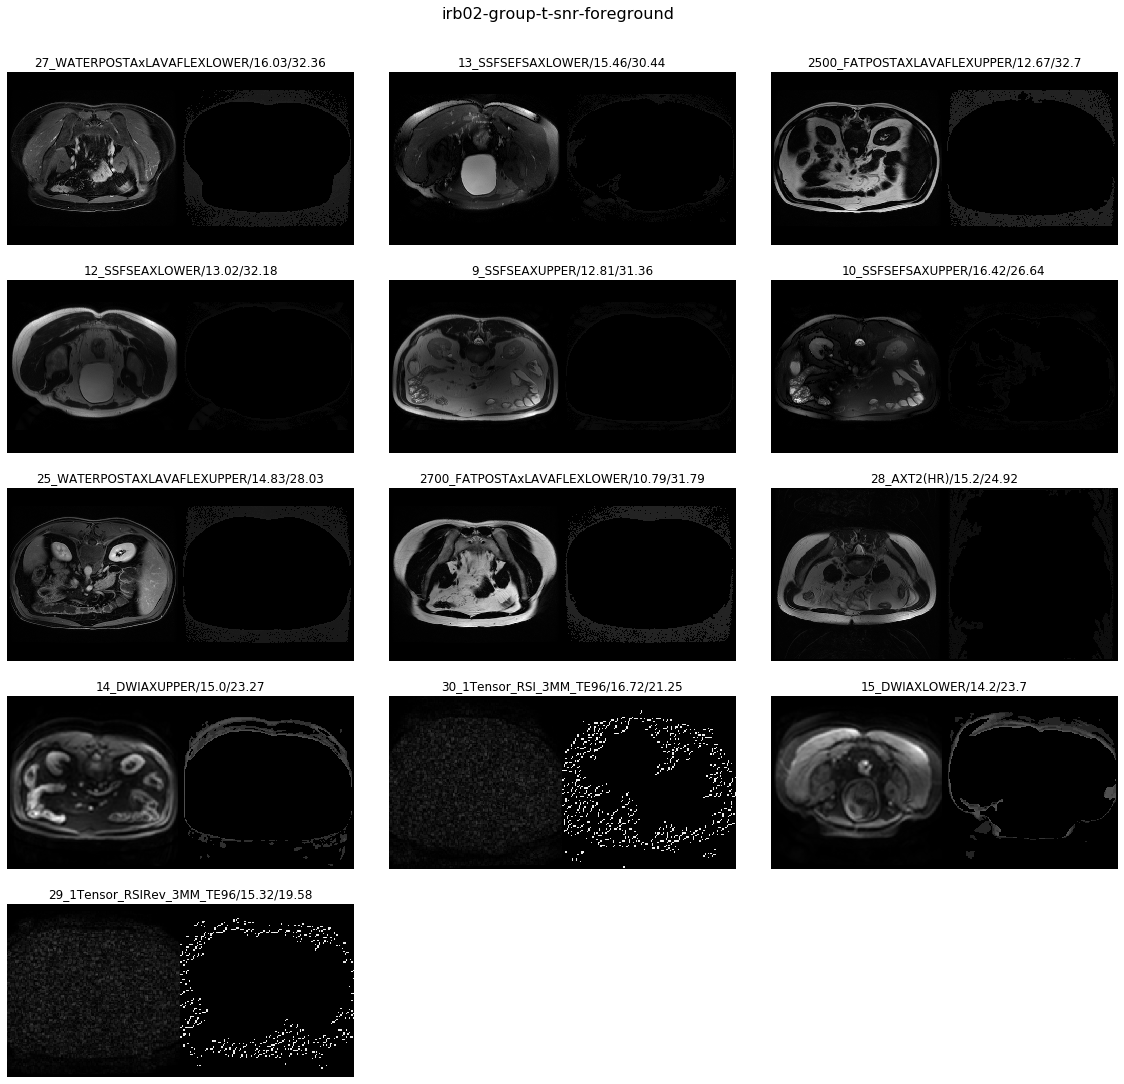

In [18]:
titles = [name+'/'+str(round(q1, 2))+'/'+str(round(q2, 2)) for name, q1,q2 in zip(sorted_names, sorted_q1,sorted_q2)]
stack_imgs = [np.hstack((f, cv2.equalizeHist(b))) for f,b in zip(sorted_original_imgs,sorted_back_imgs)]
imshow_15('irb02-group-t-snr-foreground', stack_imgs, titles)


In [ ]:
# titles = [name+'/'+str(round(q1, 2)) for name, q1 in zip(np_names[group_t_ids], np_gof[group_t_ids])]

# imshow_15('group t', np_oris[group_t_ids], titles)

In [ ]:
# titles = [name+'/'+str(round(q1, 2)) for name, q1 in zip(np_names[group_c_ids], np_q1[group_c_ids])]

# imshow_15('group t', np_oris[group_c_ids], titles)

In [ ]:
imshow_25('test', ori_imgs, folder_names)

In [ ]:
q1,gof = getQI2(F, B, c, f, b)
print("===")
print(q1)
print(gof)

In [ ]:
q12,gof2 = getQI2(F2, B2, c2, f2, b2)
print("===")
print(q12)
print(gof2)

In [ ]:
yi=2
sigma=np.nanstd(b2)
pdf = yi*math.exp(0.5 * (yi**2/sigma))/sigma

In [ ]:
pdf

In [ ]:

tb = B2.flatten()
ntb = [x for x in tb if x>0]
hist,bins = np.histogram(ntb,256,[0,256])

In [ ]:
hist[:10]
# threshold_hist = [x for x in hist[1:] if x > 0]
# sum(threshold_hist)

In [ ]:
tr = np.where(hist == hist.max())
bins[tr]

In [ ]:
tb = B2.flatten()
len(tb)

In [ ]:
ntb = [x for x in tb if x>0]
len(ntb)

In [ ]:
n, b, patches = plt.hist(ntb, len(np.unique(ntb)), density=True, stacked=True)

bin_max = np.where(n == n.max())
bin_max
print(n)
print(b)

# print(patches)

In [ ]:
hist_mask = cv2.calcHist([F2],[0],None,[256],[0,256])


In [ ]:
equ1 = cv2.equalizeHist(F)
equ2 = cv2.equalizeHist(F2)
imshow_double(equ1,equ2,"background")

In [ ]:
hist_mask = cv2.calcHist([equ1],[0],None,[256],[0,256])

plt.plot(hist_mask)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n, b, patches = plt.hist(F.flatten(), 50, normed=1, histtype='stepfilled')

bin_max = np.where(n == n.max())

# print 'maxbin', b[bin_max][0]

In [ ]:
F.shape

In [ ]:
256*256